# Complementaria Semana 7: Transformada Inversa para Generación de Variables Aleatorias (GVA)

En esta complementaria aprenderemos a **generar variables aleatorias continuas** a partir de una fuente básica de aleatoriedad: una uniforme `U ~ Unif(0,1)`.

La idea central es:

$$
X = F^{-1}(U) \quad \text{donde } U \sim \text{Unif}(0,1)
$$

donde $F$ es la CDF (función de distribución acumulada) de $X$.

### Objetivos

Al final de esta guía podrás:

1. Entender por qué $F(X)\sim \text{Unif}(0,1)$ y cómo eso implica $X=F^{-1}(U)$.
2. Derivar $F^{-1}$ para distribuciones continuas simples.
3. Implementar algoritmos de generación por **transformada inversa** en Python.
4. Validar empíricamente los resultados (histogramas, comparación con pdf, cuantiles).


### Librerías que usaremos
- `numpy` para muestreo y cálculo numérico
- `matplotlib` para visualización
- `math` para funciones matemáticas
- `scipy.stats` para validaciones (KS-test, pdf/cdf)


Si aún no están instaladas en el entorno, utilizar este comando en una celda de python (no es necesario instalar `math`):

In [1]:
pip install numpy matplotlib scipy


[notice] A new release of pip is available: 25.3 -> 26.0
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


Posteriormente, importar las librerías:

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import stats

# ¿Cómo funciona la Transformada Inversa?

Antes de programar, es clave entender **qué problema estamos resolviendo**.

## El problema central

En un computador, el generador básico de números aleatorios produce valores:

$$U \sim \text{Unif}(0,1)$$

Es decir, sabemos generar **uniformes**, pero **no directamente** exponenciales, normales, Weibull, etc.

La pregunta es:

> ¿Cómo usamos una uniforme para generar una variable aleatoria con una distribución cualquiera?


## Idea clave

Sea $X$ una variable aleatoria continua con función de distribución acumulada (CDF) $F$.

Entonces ocurre algo muy importante:

$$U = F(X) \sim \text{Unif}(0,1)$$

Es decir, **si evaluamos la CDF de una variable aleatoria en su propio valor, el resultado es uniforme**.


## ¿Por qué pasa esto? (intuición + argumento corto)

La CDF $F(x)$ nos dice:

> la probabilidad de que $X$ sea menor o igual que $x$.

Si tomamos $U = F(X)$, entonces para cualquier $u \in [0,1]$:

$$P(U \le u) = P(F(X) \le u) = P(X \le F^{-1}(u)) = F(F^{-1}(u)) = u$$

Esto es exactamente la CDF de una **Uniforme(0,1)**.


## La idea se puede \"dar la vuelta\"

Si:
- $F(X)$ es uniforme,
- y sabemos generar $U \sim \text{Unif}(0,1)$,

entonces podemos **invertir el proceso**:

$$X = F^{-1}(U)$$

y así obtener una variable $X$ con la distribución deseada.

**Este es el método de la transformada inversa.**


## ¿Qué necesitamos en la práctica?

Para usar la transformada inversa necesitamos:

1. Saber la CDF $F(x)$ de la distribución objetivo.
2. Poder despejar $x$ en función de $u$, es decir, calcular $F^{-1}(u)$.
3. Generar valores $U \sim \text{Unif}(0,1)$.
4. Aplicar la fórmula $X = F^{-1}(U)$.

## Fuente de aleatoriedad: generador por congruencia lineal (LCG)

En la sección anterior asumimos que el computador puede producir directamente valores
$$
U \sim \mathrm{Unif}(0,1).
$$
En la práctica, esa uniforme proviene de un **generador pseudoaleatorio**: un algoritmo determinista que produce una secuencia larga de números que *se comporta* como aleatoria.

Un generador clásico y fácil de analizar es el **generador congruencial lineal** (*Linear Congruential Generator*, LCG):

$$
X_{k+1} = (aX_k + c) \bmod m,
\qquad
U_{k+1} = \frac{X_{k+1}}{m}.
$$

- $X_k$ es el **estado** (un entero).
- $m$ es el **módulo** (define el rango de estados: $0,1,\dots,m-1$).
- $a$ es el **multiplicador** y $c$ el **incremento**.

La secuencia $\{U_k\}$ se usa como fuente básica de uniformes, y luego aplicamos la **transformada inversa**
para construir variables con otras distribuciones (Exponencial, Weibull, etc.).

**Importante:** el LCG es determinista. Con la misma semilla $X_0$ produce exactamente la misma secuencia.
Eso es útil en simulación porque garantiza **reproducibilidad**.

En este laboratorio usaremos un conjunto de parámetros estándar (con buen periodo para fines didácticos):
- $m = 2^{31}-1$ (primo de Mersenne),
- $a = 16807$,
- $c = 0$.

Este caso se conoce como el *minimal standard* de Park–Miller.


In [3]:
# Implementación simple de un generador congruencial lineal (LCG)
# Retorna una lista/array de U en (0,1).

def lcg_uniform(n, seed, a=16807, c=0, m=2147483647):
    """Genera n pseudo-uniformes U ~ Unif(0,1) usando un LCG.

    Parámetros:
    - n: número de valores a generar
    - seed: semilla entera (estado inicial X0). Debe ser 1..m-1 para este LCG multiplicativo.
    - a, c, m: parámetros del generador

    Retorna:
    - np.array de tamaño n con valores en (0,1)
    """
    # Aseguramos que la semilla esté en el rango permitido
    x = int(seed) % m
    if x == 0:
        x = 1  # evitamos el estado 0 (en el caso c=0 se queda atrapado)

    U = []
    for _ in range(n):
        x = (a * x + c) % m
        # Convertimos a (0,1). Usamos m como escala.
        U.append(x / m)
    return np.array(U)

# Pequeña prueba rápida (opcional)
U_test = lcg_uniform(10, seed=123)
U_test

array([9.62643419e-04, 1.79147942e-01, 9.39454630e-01, 4.13966227e-01,
       5.30370202e-01, 9.31979918e-01, 7.86487794e-01, 5.00360175e-01,
       5.53457918e-01, 9.67226201e-01])

Media empírica: 0.5020793585805872  | Teórica: 0.5
Var empírica : 0.08358436772439962  | Teórica: 0.08333333333333333


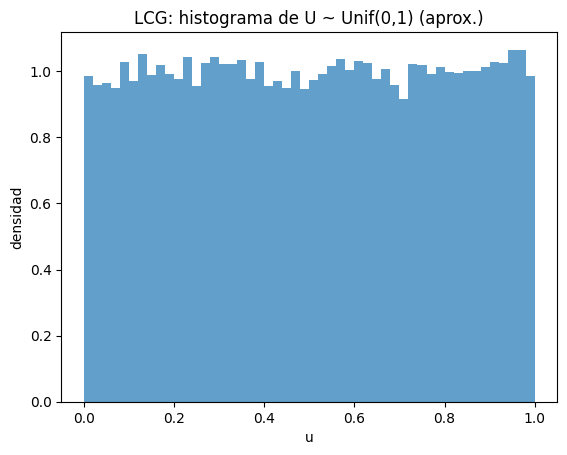

In [4]:
# Validación muy básica del LCG: histograma + media/varianza esperadas de Unif(0,1)
# (Esto NO prueba 'aleatoriedad', solo da una verificación rápida de plausibilidad.)

n_check = 50000
U = lcg_uniform(n_check, seed=2026)

plt.figure()
plt.hist(U, bins=50, density=True, alpha=0.7)
plt.title("LCG: histograma de U ~ Unif(0,1) (aprox.)")
plt.xlabel("u")
plt.ylabel("densidad")

print("Media empírica:", U.mean(), " | Teórica:", 0.5)
print("Var empírica :", U.var(ddof=1), " | Teórica:", 1/12)

# Ejemplo guiado — Exponencial($\lambda$)

En este ejemplo aplicaremos el método de la **transformada inversa** para generar variables aleatorias con distribución exponencial, una de las distribuciones continuas más importantes en simulación (por ejemplo, para modelar tiempos entre eventos).

El objetivo es:
- derivar explícitamente la inversa de la CDF,
- implementarla en Python,
- y verificar empíricamente que los datos generados siguen una distribución exponencial.

<br><br>

Sea $X \sim \text{Exp}(\lambda)$ con $\lambda > 0$, su función de distribución acumulada (CDF) es:

$$
F(x) = 1 - e^{-\lambda x}, \quad x \ge 0
$$


### Cálculo de la transformada inversa

Para aplicar el método, igualamos la CDF a una variable uniforme $U \sim \text{Unif}(0,1)$ y despejamos $x$:

$$
u = 1 - e^{-\lambda x}
$$

$$
e^{-\lambda x} = 1 - u
$$

$$
-\lambda x = \ln(1 - u)
$$

$$
x = -\frac{1}{\lambda} \ln(1 - u)
$$

Como $U \sim \text{Unif}(0,1)$ implica que $1 - U \sim \text{Unif}(0,1)$, se suele usar la forma equivalente:

$$
X = -\frac{1}{\lambda} \ln(U)
$$

### Procedimiento aplicado al caso Exponencial

1. Generar $U_1,\dots,U_n \sim \text{Unif}(0,1)$.
2. Calcular $X_i = F^{-1}(U_i)$, en este caso $X_i = -\frac{1}{\lambda}\ln(U_i)$.
3. Validar empíricamente los resultados mediante:
   - Un histograma de los $X_i$
   - Comparación con la pdf teórica, en este caso $f(x)=\lambda e^{-\lambda x}$
   - Cálculo de la media y varianza muestral
   - Test KS (opcional)


In [5]:
# Parámetros del experimento (Exponencial)

lam = 2
n = 50000

# Elegir la fuente de uniformes:
# - True  : usar nuestro LCG (congruencia lineal)
# - False : usar el generador de NumPy (por defecto)
USAR_LCG = True

# Semillas (reproducibilidad)
seed_lcg = 123
rng = np.random.default_rng(0)  # si USAR_LCG=False, se usa esta semilla


In [6]:
# 1. Generar U ~ Unif(0,1)

if USAR_LCG:
    # Uniformes producidas por congruencia lineal
    U = lcg_uniform(n, seed=seed_lcg)
else:
    # Uniformes producidas por el generador de NumPy
    U = rng.random(n)

# Nota numérica:
# log(0) no está definido. Por seguridad, evitamos valores extremadamente cercanos a 0.
U = np.maximum(U, 1e-12)

# 2. Calcular X ~ Exp(lam) con la transformada inversa
#    Si F(x)=1-exp(-lam x), entonces F^{-1}(u)=-(1/lam) log(1-u).
#    Como U y 1-U tienen la misma distribución Unif(0,1), usamos:
X = -(1/lam) * np.log(U)


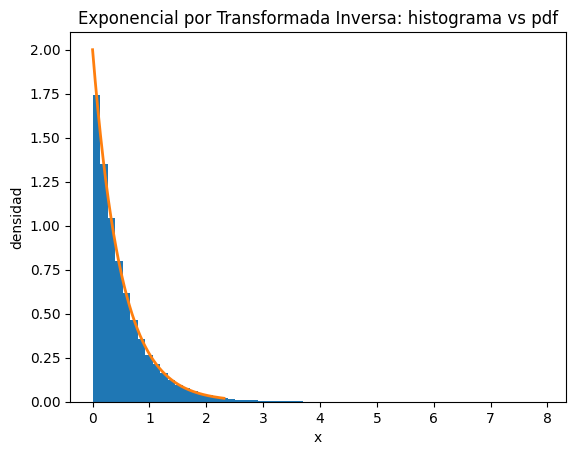

In [7]:
# 3. Validación empírica: histograma + pdf teórica

plt.figure()

# Histograma normalizado de las muestras simuladas
plt.hist(X, bins=60, density=True) 
            # bins: en cuántos intervalos (barras) se divide el rango de los datos.
            # density=True: Normaliza el histograma para que represente una densidad de probabilidad, no conteos.

# Malla de valores donde se evalúa la pdf teórica
xgrid = np.linspace(0, np.quantile(X, 0.99), 400)
                        # Se usa el percentil 99 para evitar colas muy largas

# Función de densidad teórica de la Exponencial(lamda) en la malla
pdf = lam * np.exp(-lam * xgrid)

# Superposición de la pdf teórica sobre el histograma
plt.plot(xgrid, pdf, linewidth=2)

# Elementos gráficos
plt.title("Exponencial por Transformada Inversa: histograma vs pdf")
plt.xlabel("x")
plt.ylabel("densidad")
plt.show()


In [8]:
# Comparar media y varianza empírica vs teórica
print("Media empírica:", X.mean(), " | Teórica:", 1/lam)
print("Var empírica :", X.var(ddof=1), " | Teórica:", 1/(lam**2))


Media empírica: 0.5016234835686951  | Teórica: 0.5
Var empírica : 0.25384200162094983  | Teórica: 0.25


Como podemos observar, el histograma de los valores simulados se ajusta muy bien a la forma de la función de densidad teórica de la distribución exponencial, lo que sugiere que el procedimiento de generación por transformada inversa está produciendo observaciones con la distribución esperada.

Adicionalmente, la media y la varianza empíricas son muy cercanas a sus valores teóricos. Estas pequeñas diferencias se deben al error muestral propio de trabajar con un número finito de observaciones y tienden a desaparecer a medida que el tamaño de la muestra aumenta.


## Validación adicional: KS test

El test de Kolmogorov–Smirnov (KS) compara la función de distribución acumulada empírica con la CDF teórica de la distribución exponencial. 

Si el procedimiento de generación es consistente con la distribución teórica, el p-value del test debería ser **mayor que un nivel de significancia $\alpha$** (por ejemplo, $\alpha=0.05$), de modo que no se rechace la hipótesis nula de que los datos provienen de dicha distribución.

**Importante:** el test KS no prueba que la distribución sea exactamente correcta; únicamente detecta discrepancias estadísticamente significativas entre la CDF empírica y la teórica. Además, para tamaños muestrales grandes, el test puede volverse muy sensible.


In [9]:
# Test KS para comparar la CDF empírica con la CDF teórica exponencial
D, p = stats.kstest(X, "expon", args=(0, 1/lam)) # En SciPy, la exponencial se parametriza con 'scale = 1/lambda'

# Estadístico KS: máxima diferencia entre CDF empírica y teórica
print("KS statistic:", D)

# p-value del test: se compara con un nivel de significancia alpha
print("p-value     :", p)

KS statistic: 0.003115473602542329
p-value     : 0.7155843801748469


# Ejercicio aplicado — Generación Weibull por Transformada Inversa

En este ejercicio aplicarás el método de la **transformada inversa** para generar variables aleatorias con distribución **Weibull**, una distribución ampliamente usada para modelar tiempos de vida y fallas en sistemas.

Sea $X \sim \text{Weibull}(k,\lambda)$, donde:
- $k>0$ es el parámetro de forma,
- $\lambda>0$ es el parámetro de escala.

Su función de distribución acumulada (CDF) es:

$$
F(x) = 1 - \exp\left(-\left(\frac{x}{\lambda}\right)^k\right), \quad x \ge 0
$$


## Parte A — Derivación de la transformada inversa

Partiendo de $u = F(x)$, derive una expresión explícita para $x = F^{-1}(u)$.

**Solución:**

Partimos de:

$$
u = 1 - \exp\left(-\left(\frac{x}{\lambda}\right)^k\right)
$$

Despejamos:

$$
\exp\left(-\left(\frac{x}{\lambda}\right)^k\right) = 1 - u
$$

$$
-\left(\frac{x}{\lambda}\right)^k = \ln(1-u)
$$

$$
\left(\frac{x}{\lambda}\right)^k = -\ln(1-u)
$$

$$
x = \lambda \left(-\ln(1-u)\right)^{1/k}
$$

Como $U\sim \text{Unif}(0,1)$ implica que $1-U\sim \text{Unif}(0,1)$, se usa comúnmente la forma equivalente:

$$
X = \lambda \left(-\ln(U)\right)^{1/k}
$$


## Parte B — Implementación en Python

1. Implemente un generador de variables Weibull usando la transformada inversa.
2. Genere $n=50\,000$ observaciones para los siguientes parámetros:
   - $k=1.5$
   - $\lambda=2$
3. Valide empíricamente los resultados mediante:
   - histograma y pdf teórica,
   - comparación de la media empírica con la media teórica,
   - test KS con nivel de significancia $\alpha=0.05$.



**Solución:**

In [ ]:
# Parámetros (Weibull)
k = 1.5
lam = 2
n = 50000

# Elegir fuente de uniformes:
USAR_LCG = True
seed_lcg = 321
rng = np.random.default_rng(1)

# Generar U ~ Unif(0,1)
if USAR_LCG:
    U = lcg_uniform(n, seed=seed_lcg)
else:
    U = rng.random(n)

# Seguridad numérica para log(0)
U = np.maximum(U, 1e-12)

# Transformada inversa Weibull
# F(x)=1-exp(-(x/lam)^k)  =>  X = lam * (-log(U))^(1/k)
X = lam * (-np.log(U))**(1/k)


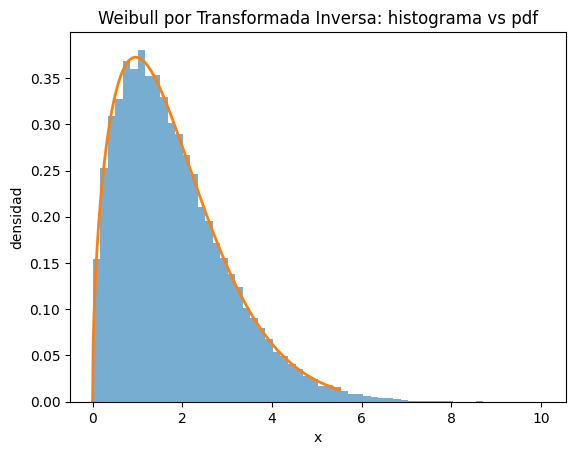

In [11]:
# Validación empírica: histograma + pdf
plt.figure()

# Histograma normalizado
plt.hist(X, bins=60, density=True, alpha=0.6)

# Malla para la pdf teórica
xgrid = np.linspace(0, np.quantile(X, 0.99), 400)

# pdf teórica Weibull
pdf = (k/lam) * (xgrid/lam)**(k-1) * np.exp(-(xgrid/lam)**k)

plt.plot(xgrid, pdf, linewidth=2)

plt.title("Weibull por Transformada Inversa: histograma vs pdf")
plt.xlabel("x")
plt.ylabel("densidad")
plt.show()


In [12]:
# Media teórica de Weibull(k, lam)
mean_theoretical = lam * math.gamma(1 + 1/k)

print("Media empírica:", X.mean())
print("Media teórica :", mean_theoretical)


Media empírica: 1.8092630644165195
Media teórica : 1.8054905859018673


In [13]:
# Test KS (en SciPy, Weibull usa 'c = k' y 'scale = lam')
D, p = stats.kstest(X, "weibull_min", args=(k, 0, lam))

print("KS statistic:", D)
print("p-value     :", p)


KS statistic: 0.004128840250833321
p-value     : 0.36048169196311963



## Parte C — Análisis

1. ¿La forma del histograma coincide con la pdf teórica?
2. ¿La media empírica es cercana a la media teórica?
3. ¿El test KS permite rechazar la hipótesis de que los datos provienen de una Weibull $(k,\lambda)$?
